<a href="https://colab.research.google.com/github/quangminh141005/Image_detection/blob/main/ASL_detect_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the testing part

In [ ]:
import struct

data = b'\x00\x00\x08\x03\x00\x00\xea\x60\x00\x00\x00\x1c\x00\x00\x00\x1c'
magic, num_images, row, cols = struct.unpack('>IIII', data)

print("Magic:", magic)         # 2051
print("Number of images:", num_images)  # 60000
print("Rows:", row)            # 28
print("Cols:", cols)           # 28


Magic: 2051
Number of images: 60000
Rows: 28
Cols: 28


In [ ]:
filename = "/train-images.idx3-ubyte"

with open(filename, 'rb') as f:
  data = f.read()

In [ ]:
print("First 20 bytes (hex):", data[:20].hex())

First 20 bytes (hex): 000008030000ea600000001c0000001c00000000


In [ ]:
import struct

# First 4 bytes
magic = struct.unpack('>I', data[:4])[0]
print("Magic number: ", magic)

# Next 4 bytes
num_images = struct.unpack('>I', data[4:8])[0]
print("Number of images:", num_images)

# Next 4 bytes
rows = struct.unpack('>I', data[8:12])[0]
cols = struct.unpack('>I', data[12:16])[0]
print(f"Image size: {rows} x {cols}")

Magic number:  2051
Number of images: 60000
Image size: 28 x 28


In [ ]:
image_start = 16
image_size = rows * cols
first_image = data[image_start:image_start + image_size]

# Convert to list of pixel value
pixels = list(first_image)
print(pixels[:50]) # show first 50 pixels

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


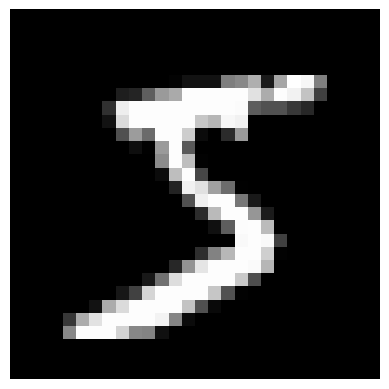

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.array(pixels).reshape(rows, cols), cmap='gray')
plt.axis('off')
plt.show()

## First step: Load and  prepare MNIST dataset

In [ ]:
import numpy as np
import gzip
import struct

def load_images(filename):
  with open(filename, 'rb') as f:
    magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
    print(f"Magic = {magic}, num = {num}, rows = {rows}, cols = {cols}")
    images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 1, rows, cols)
    return images.astype(np.float32) / 255.0

def load_labels(filename):
  with open(filename, 'rb') as f:
    magic, num = struct.unpack(">II", f.read(8))
    labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [ ]:
X_train = load_images("/content/train-images.idx3-ubyte")
y_train = load_labels("/content/train-labels.idx1-ubyte")
X_test = load_images("/content/t10k-images.idx3-ubyte")
y_test = load_labels("/content/t10k-labels.idx1-ubyte")

print("Train images shape: ", X_train.shape)
print("Train labels shape: ", y_train.shape)
print("Test images shape: ", X_test.shape)

Magic = 2051, num = 60000, rows = 28, cols = 28
Magic = 2051, num = 10000, rows = 28, cols = 28
Train images shape:  (60000, 1, 28, 28)
Train labels shape:  (60000,)
Test images shape:  (10000, 1, 28, 28)


`im2col` helps with turning the image into many small overlapping patches, and then arranges those patches into rows of a big matrix

In [ ]:
print(X_train.shape)
print(y_train.shape)


(60000, 1, 28, 28)
(60000,)


In [ ]:
print(X_train.min(), X_train.max())

0.0 1.0


In [15]:
import numpy as np

def im2col(image, kernel_size, stride):
  H, W = image.shape
  KH = KW = kernel_size
  out_h = (H - KH) // stride + 1
  out_w = (W - KW) // stride + 1

  cols = []
  for i in range(0, out_h):
    for j in range(0, out_w):
      patch = image[i * stride:i * stride + KH, j * stride: j * stride + KW]
      cols.append(patch.flatten())

  return np.array(cols)

In [16]:
img = np.arange(9).reshape(3,-1)
print(img)
print(im2col(img, 2, 1))

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[0 1 3 4]
 [1 2 4 5]
 [3 4 6 7]
 [4 5 7 8]]


In [ ]:
|class Conv2D:
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding

    scale = np.sqrt(1. / (in_channels * kernel_size * kernel_size))
    self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * scale
    self.biases = np.zeros(out_channels)

